# Применение свертичных нейронных сетей

<a name='1'></a>
## 1 - Импорт библиотек

In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.python.framework import ops

%matplotlib inline
np.random.seed(1)

<a name='1-1'></a>
### 1.1 - Загрузка датасета и его деление на Train/Test части

Для данного упражнения будет использован *happy* датасет. Задача заключается в том, чтобы реализовать сверточную нейронную сеть, которая поможет отличить грустных людей от счастливых. 

In [2]:
def load_dataset(path_to_train, path_to_test):
    train_dataset = h5py.File(path_to_train, 'r')
    train_x = np.array(train_dataset['train_set_x'][:])
    train_y = np.array(train_dataset['train_set_y'][:])

    test_dataset = h5py.File(path_to_test, 'r')
    test_x = np.array(test_dataset['test_set_x'][:])
    test_y = np.array(test_dataset['test_set_y'][:])

    # y после reshape
    train_y = train_y.reshape((1, train_x.shape[0]))
    test_y = test_y.reshape((1, test_y.shape[0]))

    return train_x, train_y, test_x, test_y

In [3]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig = load_dataset("train_happy.h5","test_happy.h5")

# Нормализация значений
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


Выведем изображения из датасета. Изображения имеют размер **64x64** пикселя в RGB формате (3 канала).

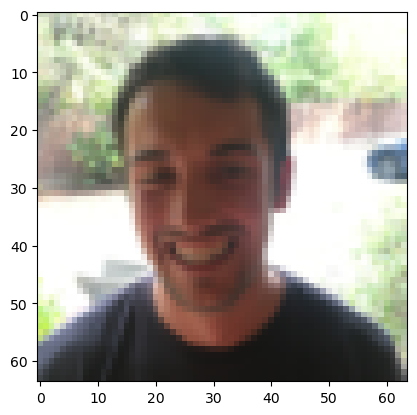

In [4]:
index = 12
plt.imshow(X_train_orig[index])
plt.show()

<a name='2'></a>
## 2 - Слои в TF Keras 

В предыдущем модули слои создавались при помощи numpy, вручную. Теперь мы будем использовать фреймворк TF Keras, в котором эти слои уже реализованы. 

Слой в TF Keras можно представить как функцию, которая принимает на вход некий тензор и преобразует его в выходной тензор, который будет использоваться последующими слоями.

<a name='3'></a>
## 3 - Последовательный (Sequential) API

Keras — это высокоуровневая абстракция, построенная на основе TensorFlow, которая позволяет упростить и оптимизировать создание и обучение моделей нейронных сетей. 

В первой части этого модуля мы создадим модель с использованием Sequential API TF Keras, которое позволяет соединять слой за слоем и особенно подходит для построения моделей, в которых каждый слой имеет **ровно один** входной тензор и **один** выходной тензор.
 
Далее мы увидим, что использование Sequential API является простым и понятным, но удобно только для описания простых нейронных сетей. Альтернативой последовательного API является функциональное API.

<a name='3-1'></a>
### 3.1 - Создание последовательной модели

TensorFlow Keras Sequential API можно использовать для создания простых моделей с последовательно идущими слоями.

Мы также можем добавлять слои в последовательную модель с помощью метода .add() или удалять их с помощью метода .pop(), так же, как мы можем это делать в обычном списке Python. На самом деле, можно воспринимать последовательную модель в виде списка слоев. Как и элементы в списке Python, слои в последовательной модели упорядочены. 

Для создания модели в  Keras нам необходимо сразу указать размерность входного слоя. Это связано с тем, что в Keras размерности весов зависят от размерностей входных данных. Веса создаются только тогда, когда модель впервые получает некоторые входные данные. Последовательные модели можно создать, передав список слоев конструктору класса Sequential.

Создайте функцию `happyModel`, в которой будет собирать модель со следующей архитектурой: `ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> FLATTEN -> DENSE`. Документация по слоям фреймворка доступна по ссылке [tf.keras.layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers) 

Параметры для слоев сети должны быть такими:

 - [ZeroPadding2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ZeroPadding2D): padding 3, входная размерность 64 x 64 x 3
 - [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D): используйте 32 фильтра размера 7x7, stride 1
 - [BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization): по третьей размерности
 - [ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU)
 - [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D): для этого слоя используйте параметры по умолчанию
 - [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten)
 - Fully-connected ([Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)) используйте полносвязный слой с 1 нейроном и функцией активации sigmoid. 
 
 
 **Обозначение:**
 
 Используйте **tfl** вместо **tensorflow.keras.layers** (см. вызов функций)

In [5]:
def happyModel():
    """
    Возвращает модель с архитектурой:
    ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
    Для простоты параметры слоев будут заданы в коде в виде констант. 
    Часто оказывается разумным задавать эти параметры в виде переменных, подаваемых на вход функции.
    
    Аргументы:
    None

    Возвращает:
    model -- модель TF Keras (объект, который содержит информацию о структуре нейронной сети и процессе ее обучения) 
    """
    model = tf.keras.Sequential([
            ## ZeroPadding2D: padding 3, входная размерность 64 x 64 x 3
            ## Conv2D: используйте 32 фильтра размера 7x7, stride 1          
            ## BatchNormalization: по третьей размерности          
            ## ReLU            
            ## Max Pooling 2D: для этого слоя используйте параметры по умолчанию            
            ## Flatten layer            
            ## Dense layer: используйте полносвязный слой с 1 нейроном и функцией активации sigmoid. 
        ])
    
    return model

In [6]:
happy_model = happyModel()
# Вывод информации для каждого слоя
happy_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 70, 70, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        4736      
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
re_lu (ReLU)                 (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

#### Ожидаемый результат:

```
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
zero_padding2d (ZeroPaddin (None, 70, 70, 3)         0         
_________________________________________________________________
conv2d (Conv2D)            (None, 64, 64, 32)        4736      
_________________________________________________________________
batch_normalization (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
re_lu (ReLU)               (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
flatten (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense (Dense)              (None, 1)                 32769     
=================================================================
Total params: 37,633
Trainable params: 37,569
Non-trainable params: 64
_________________________________________________________________
```

Теперь, когда  модель создана, мы можем скомпилировать ее для обучения с помощью оптимизатора и функции потерь, которые мы выберем. Если строка `accuracy` используется в качестве метрики, тип используемой точности будет автоматически подобран на основе используемой функции потерь (например, BinaryAccuracy или CategoricalAccuracy). Это одна из многих функций, встроенных в TensorFlow, которые облегчают нашу жизнь. Если вы хотите узнать больше о том, как работает компилятор, ознакомьтесь с  [документацией](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile).

In [7]:
happy_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

<a name='3-2'></a>
### 3.2 - Обучение и вызов модели

После создания модели, ее компиляции с выбранным нами оптимизатором и функцией потерь мы готовы начать ее обучение.

Просто вызовите метод `.fit()` для начала обучения.

In [8]:
happy_model.fit(X_train, Y_train, epochs=10, batch_size=16)

Epoch 1/10
38/38 [==============================] - 1s 24ms/step - loss: 1.3989 - accuracy: 0.6800
Epoch 2/10
38/38 [==============================] - 1s 24ms/step - loss: 0.2845 - accuracy: 0.8833
Epoch 3/10
38/38 [==============================] - 1s 23ms/step - loss: 0.1715 - accuracy: 0.9283
Epoch 4/10
38/38 [==============================] - 1s 23ms/step - loss: 0.0880 - accuracy: 0.9700
Epoch 5/10
38/38 [==============================] - 1s 24ms/step - loss: 0.1506 - accuracy: 0.9417
Epoch 6/10
38/38 [==============================] - 1s 24ms/step - loss: 0.0905 - accuracy: 0.9633
Epoch 7/10
38/38 [==============================] - 1s 24ms/step - loss: 0.0690 - accuracy: 0.9783
Epoch 8/10
38/38 [==============================] - 1s 25ms/step - loss: 0.1147 - accuracy: 0.9600
Epoch 9/10
38/38 [==============================] - 1s 24ms/step - loss: 0.2316 - accuracy: 0.9233
Epoch 10/10
38/38 [==============================] - 1s 24ms/step - loss: 0.0763 - accuracy: 0.9817


После завершения обучения используйте метод `.evaluate()` для оценки модели на *test* части датасета. Этот метод выведет значение функции потерь и метрики, указанные при компиляции модели. В данном случае это «binary_crossentropy» и «accuracy» соответственно.

In [9]:
happy_model.evaluate(X_test, Y_test)

5/5 [==============================] - 0s 6ms/step - loss: 0.1290 - accuracy: 0.9467


[0.1289973258972168, 0.9466666579246521]

In [10]:
tf.saved_model.save(happy_model, "./sm/")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./sm/assets


Пока что построение модели было довольно простой задачей. Но что, если нам нужно построить модель с общими слоями, ветвлением или несколькими входными и выходными данными? В этом случае применение Sequential API может быть быть затруднительно.

<a name='4'></a>
## 4 - Функциональное (Functional) API

В этой части модуля мы будем использовать [функциональное API](https://www.tensorflow.org/guide/keras/functional) для построения сверточной сети, которая сможет распознавать 6 цифр, изображенных на пальцах.

Функциональный API может задавать модели с нелинейной топологией, общими слоями, а также слоями с несколькими входами или выходами. По сравнению с Sequential API, Functional API обеспечивает гораздо большую гибкость.

Примером нелинейного построения модели может служить рисунок, изображенный ниже. На нем первый слой напрямую соединен с третьим, что, очевидно, позволяет передавать выход первого слоя сразу на третий, в обход второго слоя. Такое соединение называют "skip connection" и его часто можно встретить в архитектурах, например, в ResNet.

<img src="images/seq_vs_func.png" style="width:350px;height:200px;">

<a name='4-1'></a>
### 4.1 - Загрузка датасета

In [11]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig,  = load_dataset("train_signs.h5", "test_signs.h5")

<img src="images/SIGNS.png" style="width:800px;height:300px;">

На изображении ниже показан пример изображение и его класс (4). Изменяя значение `index` можно просмотреть другие изображения в датасете.

y = 4


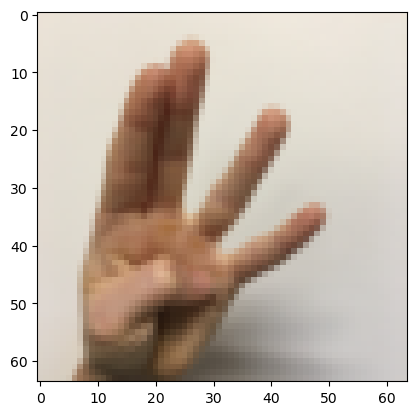

In [12]:
index = 9
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

<a name='4-2'></a>
### 4.2 - Разбиение датасета на Train/Test части

In [13]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = tf.squeeze(tf.one_hot(Y_train_orig, 6))
Y_test = tf.squeeze(tf.one_hot(Y_test_orig, 6))
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


<a name='4-3'></a>
### 4.3 - Построение модели

Документация по функциональному API доступна здесь [Functional API](https://www.tensorflow.org/guide/keras/functional). При использовании этого API мы, по сути, создаем граф, вершинами которого являются слои. Такой подход обеспечивает нам высокую степень гибкости модели.

Модель, которую мы будем рассматривать далее также может быть задана с использованием последовательного API, однако в этом задании мы будем использовать именно функциональный API.

Начнем построение графа слоев с создания входного слоя.

- **input_img = tf.keras.Input(shape=input_shape):** 

Затем создадим новыую вершину в графе, вызвав слой Conv2D и подав ему на вход объект `input_img`:

- **tf.keras.layers.Conv2D(filters= ... , kernel_size= ... , padding='same')(input_img):** Документация по слою [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D).

- **tf.keras.layers.MaxPool2D(pool_size=(f, f), strides=(s, s), padding='same'):** `MaxPool2D()` уменьшим размерности тензора при помощи окна размером (f, f) и величиной сдвига окна (stride) (s, s).  Документация для слоя доступна тут [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D).

- **tf.keras.layers.ReLU():** вычисление функции активации [ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU).

- **tf.keras.layers.Flatten()**: принимая на вход тензор "P", эта функция преобразует его в одномерный вектор

    * Если тензор P имеет размерности (batch_size,h,w,c), flatten возвращает тензор размерностью (batch_size, k), где $k=h \times w \times c$.  "k" является произведением всех размерностей (за исключением batch size). [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten).
     

- **tf.keras.layers.Dense(units= ... , activation='softmax')(F):** принимая на вход одномерный тензор F, возвращает выход послосвязного слоя. [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense).


Наконец, нам необходимо определить выходные данные, которые определяются выходным слоем (в данном случае полносвязным). Обратите внимание, что так как у нас
6 классов, то и выходных нейронов будет 6:

- **outputs = tf.keras.layers.Dense(units=6, activation='softmax')(F)**

Напишите функцию `convolutional_model`, которая собирает следующую архитектуру: `CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE`. Используйте функции, описанные выше.

Параметры слоев должны быть следующие:

 - [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D): Используйте 8 фильтров размера 4 на 4, шаг свертки 1, padding - "SAME"
 - [ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU)
 - [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D): Используйте 8 фильтров размера 8 на 8, шаг 8 на 8, padding - "SAME"
 - **Conv2D**: Используйте 16 фильтров размера 2 на 2, шаг 1, padding - "SAME"
 - **ReLU**
 - **MaxPool2D**: Используйте 1 фильтр размера 4 на 4, шаг 4 на 4, padding - "SAME"
 - [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten)
 - Fully-connected ([Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)) в качестве последнего слоя используйте полносвязный слой с 6 нейронами, функция активации - softmax

In [14]:
def convolutional_model(input_shape):
    """
    Собирает следующую архитектуру нейронной сети:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
    Аргументы:
    input_img -- входной тензор размера (input_shape)

    Returns:
    model -- модель TF Keras
    """

    input_img = tf.keras.Input(shape=input_shape)
    # CONV2D: 8 фильтров 4x4, шаг 1, padding 'SAME'
    Z1 = None
    # RELU
    A1 = None
    # MAXPOOL: окно 8x8, шаг 8, padding 'SAME'
    P1 = None
    # CONV2D: 16 фильтров 2x2, шаг 1, padding 'SAME'
    Z2 = None
    # RELU
    A2 = None
    # MAXPOOL: окно 4x4, шаг 4, padding 'SAME'
    P2 = None
    # FLATTEN
    F = None
    # Dense layer
    # 6 нейрово в выходном слое. Один из аргументов должен быть "activation='softmax'" 
    outputs = None
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [15]:
conv_model = convolutional_model((64, 64, 3))
conv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()
    

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 8)         392       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 64, 64, 8)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 16)          528       
_________________________________________________________________
re_lu_2 (ReLU)               (None, 8, 8, 16)          0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 16)         

#### Ожидаемый результат:

```
Model: "functional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input (InputLayer)           [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 8)         392       
_________________________________________________________________
re_lu (ReLU)                 (None, 64, 64, 8)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 16)          528       
_________________________________________________________________
re_lu (ReLU)                 (None, 8, 8, 16)          0         
_________________________________________________________________
max_pooling2d   (MaxPooling2 (None, 2, 2, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
=================================================================
Total params: 1,310
Trainable params: 1,310
Non-trainable params: 0
_________________________________________________________________
```

Both the Sequential and Functional APIs return a TF Keras model object. The only difference is how inputs are handled inside the object model! 

<a name='4-4'></a>
### 4.4 - Train the Model

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(64)
history = conv_model.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100
17/17 [==============================] - 0s 22ms/step - loss: 1.8170 - accuracy: 0.1667 - val_loss: 1.7907 - val_accuracy: 0.1667
Epoch 2/100
17/17 [==============================] - 0s 20ms/step - loss: 1.7887 - accuracy: 0.1694 - val_loss: 1.7820 - val_accuracy: 0.2000
Epoch 3/100
17/17 [==============================] - 0s 19ms/step - loss: 1.7827 - accuracy: 0.2370 - val_loss: 1.7760 - val_accuracy: 0.3000
Epoch 4/100
17/17 [==============================] - 0s 18ms/step - loss: 1.7783 - accuracy: 0.2741 - val_loss: 1.7713 - val_accuracy: 0.3667
Epoch 5/100
17/17 [==============================] - 0s 22ms/step - loss: 1.7742 - accuracy: 0.2926 - val_loss: 1.7671 - val_accuracy: 0.3750
Epoch 6/100
17/17 [==============================] - 0s 19ms/step - loss: 1.7695 - accuracy: 0.3167 - val_loss: 1.7619 - val_accuracy: 0.4000
Epoch 7/100
17/17 [==============================] - 0s 18ms/step - loss: 1.7645 - accuracy: 0.3148 - val_loss: 1.7557 - val_accuracy: 0.4167
Epoch 

<a name='5'></a>
## 5 - Объект History 

Метод `.fit()` на выходе дает объект history, который содержит запись всех метрик, получаемых во время обучения. Они хранятся в словаре, получить доступ к которомо можно следующий образом: `history.history`: 

In [17]:
history.history

{'loss': [1.817047357559204,
  1.788735270500183,
  1.7826520204544067,
  1.778319239616394,
  1.7742124795913696,
  1.7695363759994507,
  1.7645481824874878,
  1.7579933404922485,
  1.7495776414871216,
  1.7383103370666504,
  1.7248966693878174,
  1.7079346179962158,
  1.6874887943267822,
  1.6618998050689697,
  1.6280486583709717,
  1.5946831703186035,
  1.555656909942627,
  1.5131163597106934,
  1.4677832126617432,
  1.4204285144805908,
  1.37338387966156,
  1.3267195224761963,
  1.2834023237228394,
  1.2414345741271973,
  1.2034679651260376,
  1.1675373315811157,
  1.1355054378509521,
  1.104175090789795,
  1.0756022930145264,
  1.0473939180374146,
  1.0240318775177002,
  0.9998931884765625,
  0.9766931533813477,
  0.9554168581962585,
  0.9369858503341675,
  0.9170676469802856,
  0.9001339077949524,
  0.8827494978904724,
  0.8667231798171997,
  0.8519251346588135,
  0.8377151489257812,
  0.8239297866821289,
  0.810580313205719,
  0.7981274724006653,
  0.7864808440208435,
  0.774562

Теперь отобразим эти метрики на графике, используя тот же словарь `history.history`: 

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

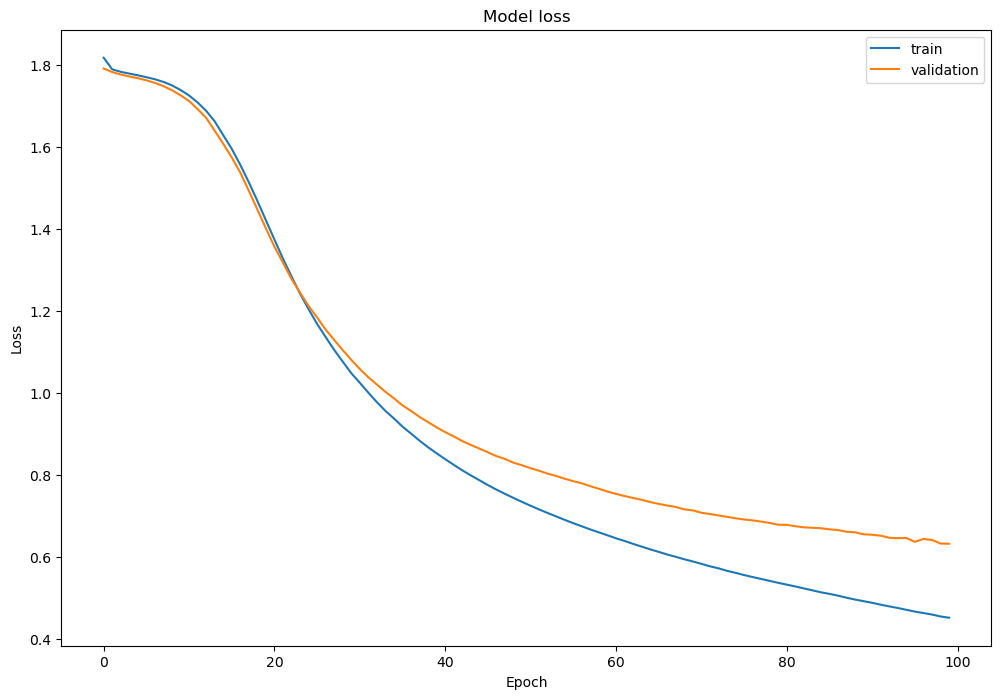

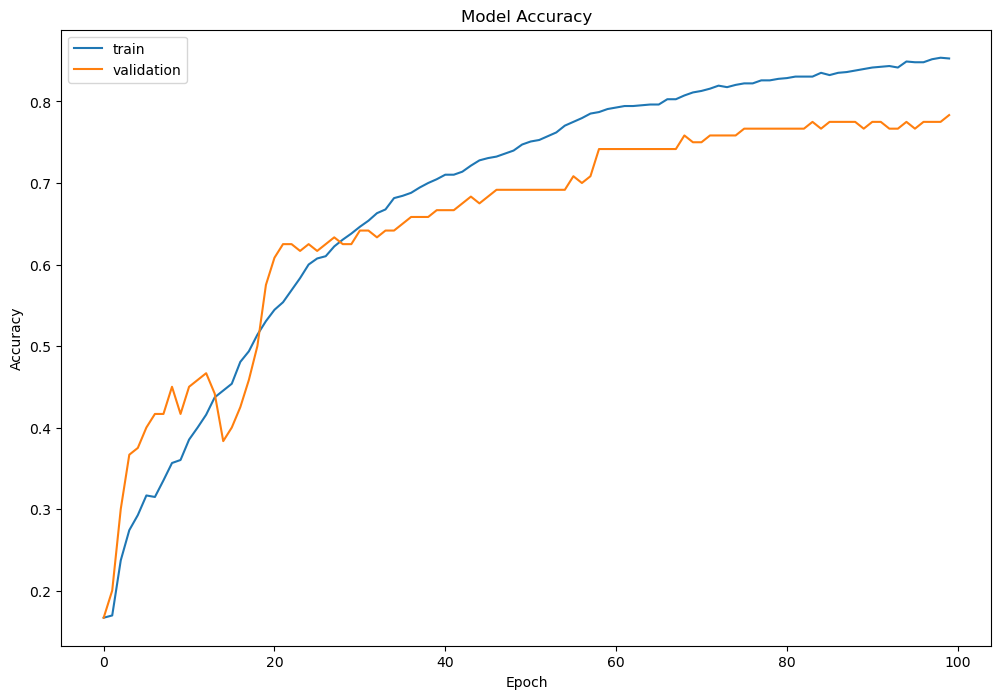

In [18]:
pd.options.mode.chained_assignment = None  # default='warn'

df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')